In [1]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Style settings
sns.set(style="whitegrid")
from IPython.core.display import display, HTML
from IPython.display import IFrame
display(HTML('<style>.container { width:100% !important; }</style>'))
matplotlib.rcParams['figure.figsize'] = [16, 8]
matplotlib.rcParams["font.family"] = "HelveticaNeue"
sns.set(font_scale=1.5)

In [3]:
gt_df = pd.DataFrame(pd.read_pickle('../inf_out/port_1_1572451294.mp4.p'))

In [6]:
gt_df.head()

,frame_idx,class_str,confidence,left_top_x,left_top_y,width,height,bitrate_kbps,total_frames,file_path,fps,detection_time
0,0,car,0.985340,236.002380,348.829041,50.172626,37.272205,1572451294,4475,./port_1_1572451294.mp4,14,1.155463
1,0,person,0.983114,429.698273,554.089233,26.473806,77.956017,1572451294,4475,./port_1_1572451294.mp4,14,1.155463
2,0,car,0.980737,280.254791,372.689758,64.146149,51.819546,1572451294,4475,./port_1_1572451294.mp4,14,1.155463
3,0,car,0.980425,338.637543,415.025146,77.769905,59.594933,1572451294,4475,./port_1_1572451294.mp4,14,1.155463
4,0,car,0.973258,120.774704,306.774384,54.524055,32.354801,1572451294,4475,./port_1_1572451294.mp4,14,1.155463


In [7]:
filelist = glob.glob('../inf_out/*.p') 
df_list = [pd.read_pickle(file) for file in filelist]
full_df = pd.DataFrame()
for df in df_list:
    f_df = pd.DataFrame(df)
    full_df = pd.concat([full_df, f_df])

In [8]:
# full_df.sort_values(by=['bitrate_kbps'], inplace=True)
full_df.head()

,frame_idx,class_str,confidence,left_top_x,left_top_y,width,height,bitrate_kbps,total_frames,file_path,fps,detection_time
0,0,car,0.985642,235.927017,348.863953,50.377953,37.627125,2100,4475,../output_video/port_1_1572451294/port_1_15724...,14,1.011575
1,0,person,0.983257,429.629028,554.103027,26.624994,78.122139,2100,4475,../output_video/port_1_1572451294/port_1_15724...,14,1.011575
2,0,car,0.982087,338.552185,415.030304,77.455017,59.809433,2100,4475,../output_video/port_1_1572451294/port_1_15724...,14,1.011575
3,0,car,0.978684,280.410797,373.020813,63.884205,51.920574,2100,4475,../output_video/port_1_1572451294/port_1_15724...,14,1.011575
4,0,car,0.974331,120.709442,306.726532,54.469501,32.185181,2100,4475,../output_video/port_1_1572451294/port_1_15724...,14,1.011575


In [9]:
full_df['bitrate_kbps'].unique()

array([      2100,       5100,       6300,       1300,        100,
            14500,      13500,      12900,      10700,       9700,
             7300,       4100,       3100,      13900,       8700,
            11700,      12500,       1500,       6500,       7900,
             5700,       2700,       9100,      10100,        700,
            13300,      14300,       1900,       6900,       3700,
             4700,       7500,      12300,      11100,       8100,
             6700,       1700,       4900,       3900,       2500,
             5500,      10300,       9300,      14100,      13100,
              500,       4500,       3500,       7700,       2900,
             5900,      12100,        900,       8300,      11300,
             5300,       2300,       1100,       6100,      13700,
            11900,       8900,        300,       9500,      10500,
             7100,       3300,       4300,      11500,       8500,
            12700, 1572451294,       9900,      10900])

In [10]:
def bb_intersection_over_union(boxA, boxB):
    # https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [11]:
def convert_to_box(x, y, w, h):
    box = [0, 0, 0, 0]
    box[0] = x
    box[1] = y
    box[2] = x + w
    box[3] = y + h
    return box

In [12]:
bitrate_iou = {'bitrate': [], 'iou_sum': [], 'ref_iou_sum': [], 'frame_idx': []}
conf_threshold = 0.01
for frame_idx in gt_df['frame_idx'].unique():
    frame_rows_gt = gt_df.loc[gt_df['frame_idx'] == frame_idx]
    
    ref_iou_bitrate_total = 0
    for gt_index, gt_row in frame_rows_gt.iterrows():
        box_b = convert_to_box(gt_row['left_top_x'], gt_row['left_top_y'], gt_row['width'], gt_row['height'])
        for gt_index_inner, gt_row_inner in frame_rows_gt.iterrows():
            if gt_row_inner['confidence'] < conf_threshold:
                    continue
            box_a = convert_to_box(gt_row_inner['left_top_x'], gt_row_inner['left_top_y'], gt_row_inner['width'], gt_row_inner['height'])
            ref_iou = bb_intersection_over_union(box_a, box_b)
            ref_iou_bitrate_total += ref_iou
            
    for bitrate in tqdm(full_df['bitrate_kbps'].unique()):
        iou_bitrate_total = 0
        
        frame_rows_bitrate = full_df.loc[(full_df['frame_idx'] == frame_idx) & (full_df['bitrate_kbps'] == bitrate)]
        
        for index, row in frame_rows_bitrate.iterrows():
            box_a = convert_to_box(row['left_top_x'], row['left_top_y'], row['width'], row['height'])
            for gt_index, gt_row in frame_rows_gt.iterrows():
                if gt_row['confidence'] < conf_threshold:
                    continue
                box_b = convert_to_box(gt_row['left_top_x'], gt_row['left_top_y'], gt_row['width'], gt_row['height'])
                iou = bb_intersection_over_union(box_a, box_b)
                
                iou_bitrate_total += iou
        
        bitrate_iou['bitrate'].append(bitrate)    
        bitrate_iou['iou_sum'].append(iou_bitrate_total)
        bitrate_iou['ref_iou_sum'].append(ref_iou_bitrate_total)
        bitrate_iou['frame_idx'].append(frame_idx)

 16%|█▌        | 12/74 [00:09<00:47,  1.30it/s]


KeyboardInterrupt: 

In [235]:
iou_df = pd.DataFrame(bitrate_iou)

In [236]:
iou_df['iou_diff'] = iou_df['ref_iou_sum'] - iou_df['iou_sum']
iou_df['iou_diff_percen'] = 100 - (100.0 * (iou_df['iou_sum'] / iou_df['ref_iou_sum']))

In [237]:
iou_df

,bitrate,iou_sum,ref_iou_sum,frame_idx,iou_diff,iou_diff_percen
0,2100,76.858252,87.788472,0,10.930220,12.450633
1,5100,85.857092,87.788472,0,1.931380,2.200038
2,6300,82.233092,87.788472,0,5.555380,6.328143
3,1300,76.205044,87.788472,0,11.583428,13.194703
4,100,69.958617,87.788472,0,17.829854,20.310018
...,...,...,...,...,...,...
360,11500,99.487168,106.167566,4000,6.680398,6.292316
361,8500,92.878390,106.167566,4000,13.289177,12.517172
362,12700,98.257378,106.167566,4000,7.910189,7.450664
363,9900,94.743651,106.167566,4000,11.423915,10.760268


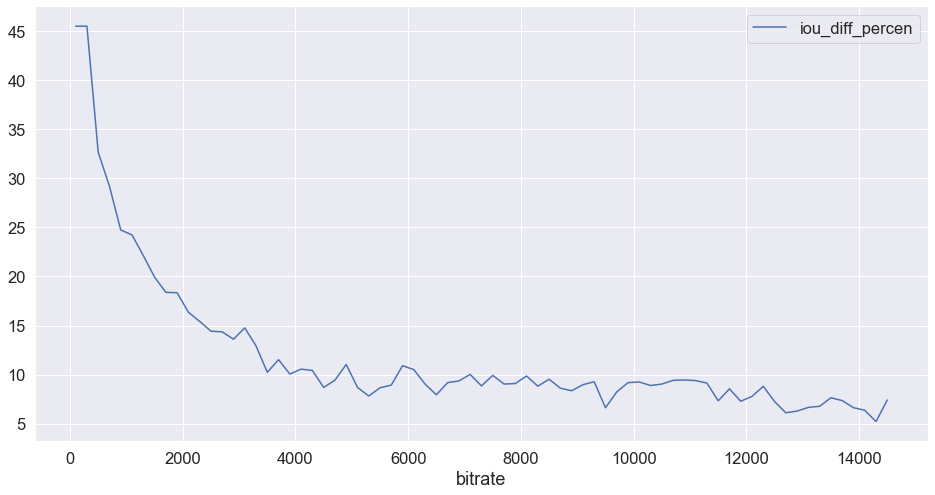

In [238]:
iou_df.groupby(['bitrate']).mean().plot(y='iou_diff_percen')